In [1]:
import numpy as np

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from sklearn import datasets
iris = datasets.load_iris()

# Load dataset
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

# Add bias term for every instance (x_0 = 1)
X_with_bias = np.c_[np.ones([len(X), 1]), X]

# Set random seed to reproduce 
# https://github.com/ageron/handson-ml/blob/master/04_training_linear_models.ipynb
np.random.seed(2042)

In [2]:
print(list(iris.keys()))

['data', 'target', 'target_names', 'DESCR', 'feature_names']


In [3]:
print(iris.DESCR)

Iris Plants Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20  0.76     0.9565  (high!)
    ============== ==== ==== ======= ===== ====================

    :Missing Attribute Values: None
  

In [4]:
# Partition off 20% of the data for testing and validation sets.
test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X_with_bias)

test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = total_size - test_size - validation_size # Should be 60% of data

rnd_indices = np.random.permutation(total_size)
print(rnd_indices)

[ 33  99 147  53  88  22  65  52  50  49  91 103  12  68  82 108  76  61
  45 107  85  58  80 137  16  43  34 117   6  74 118  17 128  66  59 122
  78  44  25  51 125 124 136 134   5 110  40 100 114 133 126  36   2  92
  96 105   1  27  63   9 121  41  60  89 112 120 132  10  18  29 142  84
 143  77  31  73  14  56 106 115  69  23 109 123  37 113   3  42  28  24
  13 146  39  32  79 130 140  21  38  47  55  72 138 149  90  98 141  67
 104  93   4  54 135 101  86  35  19  87  64 119  70 139 102  81  71  62
  11  30   7 116  46  97 129  26  95  75 127 145 131   8 144  57   0 148
  48  20  83  15 111  94]


In [5]:
X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]
X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = y[rnd_indices[train_size:-test_size]]
X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]

In [6]:
def to_one_hot(y):
    n_classes = y.max() + 1
    m = len(y)
    Y_one_hot = np.zeros((m, n_classes))
    Y_one_hot[np.arange(m), y] = 1
    return Y_one_hot

In [7]:
y_train[:10] # First 10 instances of training set without one-hot encoding

array([0, 1, 2, 1, 1, 0, 1, 1, 1, 0])

In [8]:
to_one_hot(y_train[:10])

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [9]:
# Set all data partitions into one-hot encoding
Y_train_one_hot = to_one_hot(y_train)
Y_valid_one_hot = to_one_hot(y_valid)
Y_test_one_hot = to_one_hot(y_test)

# Function below define by latex expression below:
# $\sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum\limits_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}}$
# Can be rendered with https://quicklatex.com/
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = np.sum(exps, axis=1, keepdims=True)
    return exps / exp_sums

n_inputs = X_train.shape[1] # == 3 (2 features plus the bias term)
n_outputs = len(np.unique(y_train))   # == 3 (3 iris classes)

In [16]:
# So the equations we will need are the cost function:
# $J(\mathbf{\Theta})=\dfrac{1}{m}\sum\limits{i=1}^{m}\sum\limits{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}$

# And the equation for the gradients:
# $\nabla_{\mathbf{\theta}^{(k)}} \, J(\mathbf{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}$

# log(0) is undefined, and should be avoided. log b (x) is only defined
# for x>0

In [17]:
# Train the softmax model
eta = 0.01
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
    error = Y_proba - Y_train_one_hot
    if iteration % 500 == 0:
        print(iteration, loss)
    gradients = 1/m * X_train.T.dot(error)
    Theta = Theta - eta * gradients

0 6.101427811958398
500 0.7488075774287958
1000 0.6331479911051975
1500 0.5625483738473714
2000 0.5153078902553915
2500 0.48111724017107554
3000 0.45483217915207436
3500 0.43368714188641483
4000 0.41608512581581814
4500 0.4010447190157491
5000 0.38793015072066606


In [18]:
print(Theta) # Each time the softmax model is trained, the Theta vector changes?

[[ 3.6792376   0.10432593 -1.99163689]
 [ 0.34429358  1.10899033  0.7507569 ]
 [-0.86724632  1.12812975  3.57619944]]


In [19]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

# Determine the percentage of accuracy
accuracy_score = np.mean(y_predict == y_valid)
print(accuracy_score)

0.9666666666666667


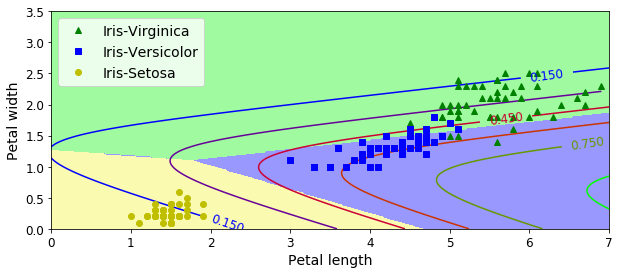

In [20]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new_with_bias = np.c_[np.ones([len(X_new), 1]), X_new]

logits = X_new_with_bias.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris-Virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris-Versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris-Setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

In [21]:
logits = X_test.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_test)
accuracy_score

0.9333333333333333